# Reducing Failure-Inducing Inputs

A standard problem in debugging is this: Your program fails after processing some large input. Only a _part_ of this input, however, is responsible for the failure. _Reducing_ the input to a failure-inducing minimum not only eases debugging – it also helps in understanding why and when the program fails. In this chapter, we present techniques that _automatically reduce and simplify failure-inducing inputs to a minimum_, notably the popular _Delta Debugging_ technique.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo("6fmJ5l257bM")

**Prerequisites**

* Using the "delta debugging" technique for reduction has no specific prerequisites.
* To understand the `DeltaDebugger` implementation, reading [the chapter on tracing](Tracer.ipynb) is recommended.

This chapter is adapted from [a similar chapter in "The Fuzzing Book"](https://www.fuzzingbook.org/html/Reducer.html). The material has been adapted to be independent from the `fuzzingbook` infrastructure, to build on general delta debugging (`dd`), and to provide a simpler invocation interface.

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.DeltaDebugger import <identifier>
```

and then make use of the following features.


A _reducer_ takes a failure-inducing input and reduces it to the minimum that still reproduces the failure.  This chapter provides a `DeltaDebugger` class that implements such a reducer.

Here is a simple example: An arithmetic expression causes an error in the Python interpreter:

```python
>>> def myeval(inp: str) -> Any:
>>>     return eval(inp)
>>> with ExpectError(ZeroDivisionError):
>>>     myeval('1 + 2 * 3 / 0')
Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/4002351332.py", line 2, in <module>
    myeval('1 + 2 * 3 / 0')
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/2200911420.py", line 2, in myeval
    return eval(inp)
  File "<string>", line 1, in <module>
ZeroDivisionError: division by zero (expected)

```
Can we reduce this input to a minimum? _Delta Debugging_ is a simple and robust reduction algorithm. We provide a `DeltaDebugger` class that is used in conjunction with a (failing) function call:

```python
with DeltaDebugger() as dd:
    fun(args...)
dd
```

The class automatically determines minimal arguments that cause the function to fail with the same exception as the original. Printing out the class object reveals the minimized call.

```python
>>> with DeltaDebugger() as dd:
>>>     myeval('1 + 2 * 3 / 0')
>>> dd
myeval(inp='3/0')
```
The input is reduced to the maximum: We get the essence of the division by zero.

There also is an interface to access the reduced input(s) programmatically. The method `min_args()` returns a dictionary in which all function arguments are minimized:

```python
>>> dd.min_args()
{'inp': '3/0'}
```
In contrast, `max_args()` returns a dictionary in which all function arguments are maximized, but still pass:

```python
>>> dd.max_args()
{'inp': '1 + 2 * 3  '}
```
The method `min_arg_diff()` returns a triple of 
* passing input,
* failing input, and
* their minimal failure-inducing difference:

```python
>>> dd.min_arg_diff()
({'inp': ' 3 '}, {'inp': ' 3 /0'}, {'inp': '/0'})
```
And you can also access the function itself, as well as its original arguments.

```python
>>> dd.function().__name__, dd.args()
('myeval', {'inp': '1 + 2 * 3 / 0'})
```
`DeltaDebugger` processes (i.e., minimizes or maximizes) all arguments that support a `len()` operation and that can be indexed – notably _strings_ and _lists_. If a function has multiple arguments, all arguments that can be processed will be processed.

This chapter also provides a number of superclasses to `DeltaDebugger`, notably `CallCollector`, which obtains the first function call for `DeltaDebugger`. `CallReducer` classes allow for implementing alternate call reduction strategies.

![](PICS/DeltaDebugger-synopsis-1.svg)



## Why Reducing?

A common problem in debugging is that given an input, only a _small part of that input may be responsible for the failure_. A central part of debugging is to _identify_ these parts – and to simplify (or _reduce_) the input to a minimal form that reproduces the failure – but does and contains as little else as possible.

Here's an example of such a situation.  We have a `mystery()` method that – given its code – can occasionally fail.  But under which circumstances does this actually happen?  We have deliberately obscured the exact condition in order to make this non-obvious.

In [2]:
import bookutils

In [3]:
import Tracer

In [4]:
from bookutils import quiz

In [5]:
def mystery(inp: str) -> None:
    x = inp.find(chr(0o17 + 0o31))
    y = inp.find(chr(0o27 + 0o22))
    if x >= 0 and y >= 0 and x < y:
        raise ValueError("Invalid input")
    else:
        pass

To find an input that causes the function to fail, let us _fuzz_ it – that is, feed it with random inputs – until we find a failing input. There's [entire books about fuzzing](https://fuzzingbook.org); but here, a very simple `fuzz()` function for this purpose will already suffice.

To build a fuzzer, we need random inputs – and thus a source for randomness. The function `random.randrange(a, b)` returns a random number in the range (a, b).

In [6]:
import random

In [7]:
random.randrange(32, 128)

107

We can use `random.randrange()` to compose random (printable) characters:

In [8]:
def fuzz() -> str:
    length = random.randrange(10, 70)
    fuzz = ""
    for i in range(length):
        fuzz += chr(random.randrange(32, 127))
    return fuzz

Here are some random strings produced by our `fuzz()` function:

In [9]:
for i in range(6):
    print(repr(fuzz()))

'N&+slk%hyp5'
"'@[3(rW*M5W]tMFPU4\\P@tz%[X?uo\\1?b4T;1bDeYtHx #UJ5"
'w}pMmPodJM,_%%BC~dYN6*g|Y*Ou9I<P94}7,99ivb(9`=%jJj*Y*d~OLXk!;J'
"!iOU8]hqg00?u(c);>:\\=V<ZV1=*g#UJA'No5QZ)~--[})Sdv#m*L"
'0iHh[-MzS.U.X}fG7aA:G<bEI\'Ofn[",Mx{@jfto}i3D?7%V7XdtO6BjYEa#Il)~]'
"E`h7h)ChX0G*m,|sosJ.mu/\\c'EpaPi0(n{"


Let us now use `fuzz()` to find an input where `mistery()` fails:

In [10]:
while True:
    fuzz_input = fuzz()
    try:
        mystery(fuzz_input)
    except ValueError:
        break

This is an input that causes `mystery()` to fail:

In [11]:
failing_input = fuzz_input
failing_input

'V"/+!aF-(V4EOz*+s/Q,7)2@0_'

In [12]:
len(failing_input)

26

In [13]:
from ExpectError import ExpectError

In [14]:
with ExpectError(ValueError):
    mystery(failing_input)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/3137704634.py", line 2, in <module>
    mystery(failing_input)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/4141878445.py", line 5, in mystery
    raise ValueError("Invalid input")
ValueError: Invalid input (expected)


Something in this input causes `mystery()` to fail.  But what is it?

## Manual Input Reduction

One important step in the debugging process is _reduction_ – that is, to identify those circumstances of a failure that are relevant for the failure to occur, and to _omit_ (if possible) those parts that are not.  As Kernighan and Pike \cite{Kernighan1999} put it:

> For every circumstance of the problem, check whether it is relevant for the problem to occur.  If it is not, remove it from the problem report or the test case in question.

Specifically for inputs, they suggest a _divide and conquer_ process:

> Proceed by binary search.  Throw away half the input and see if the output is still wrong; if not, go back to the previous state and discard the other half of the input.

This is something we can easily try out, using our last generated input:

In [15]:
failing_input

'V"/+!aF-(V4EOz*+s/Q,7)2@0_'

For instance, we can see whether the error still occurs if we only feed in the first half:

In [16]:
half_length = len(failing_input) // 2   # // is integer division
first_half = failing_input[:half_length]
first_half

'V"/+!aF-(V4EO'

In [17]:
with ExpectError(ValueError):
    mystery(first_half)

Nope – the first half alone does not suffice.  Maybe the second half?

In [18]:
second_half = failing_input[half_length:]
assert first_half + second_half == failing_input
second_half

'z*+s/Q,7)2@0_'

In [19]:
with ExpectError(ValueError):
    mystery(second_half)

This did not go so well either.  We may still proceed by cutting away _smaller chunks_ – say, one character after another.  If our test is deterministic and easily repeated, it is clear that this process eventually will yield a reduced input.  But still, it is a rather inefficient process, especially for long inputs.  What we need is a _strategy_ that effectively minimizes a failure-inducing input – a strategy that can be automated.

## Delta Debugging

One strategy to effectively reduce failure-inducing inputs is _delta debugging_ \cite{Zeller2002}.  Delta Debugging implements the "binary search" strategy, as listed above, but with a twist: If neither half fails (also as above), it keeps on cutting away smaller and smaller chunks from the input, until it eliminates individual characters.  Thus, after cutting away the first half, we cut away
the first quarter, the second quarter, and so on.

Let us illustrate this on our example, and see what happens if we cut away the first quarter.

In [20]:
quarter_length = len(failing_input) // 4
input_without_first_quarter = failing_input[quarter_length:]
input_without_first_quarter

'F-(V4EOz*+s/Q,7)2@0_'

In [21]:
with ExpectError(ValueError):
    mystery(input_without_first_quarter)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/2963114098.py", line 2, in <module>
    mystery(input_without_first_quarter)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/4141878445.py", line 5, in mystery
    raise ValueError("Invalid input")
ValueError: Invalid input (expected)


Ah! This has failed, and reduced our failing input by 25%.  Let's remove another quarter.

In [22]:
input_without_first_and_second_quarter = failing_input[quarter_length * 2:]
input_without_first_and_second_quarter

'Oz*+s/Q,7)2@0_'

In [23]:
with ExpectError(ValueError):
    mystery(input_without_first_and_second_quarter)

This is not too surprising, as we had that one before:

In [24]:
second_half

'z*+s/Q,7)2@0_'

In [25]:
input_without_first_and_second_quarter

'Oz*+s/Q,7)2@0_'

How about removing the third quarter, then?

In [26]:
input_without_first_and_third_quarter = failing_input[quarter_length:
                                                      quarter_length * 2] + failing_input[quarter_length * 3:]
input_without_first_and_third_quarter

'F-(V4EQ,7)2@0_'

In [27]:
with ExpectError(ValueError):
    mystery(input_without_first_and_third_quarter)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/4218135276.py", line 2, in <module>
    mystery(input_without_first_and_third_quarter)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/4141878445.py", line 5, in mystery
    raise ValueError("Invalid input")
ValueError: Invalid input (expected)


Yes!  This has succeeded.  Our input is now 50% smaller.

We have now tried to remove pieces that make up $\frac{1}{2}$ and $\frac{1}{4}$ of the original failing string.  In the next iteration, we would go and remove even smaller pieces – $\frac{1}{8}$, $\frac{1}{16}$ and so on.  We continue until we are down to $\frac{1}{26}$ – that is, individual characters.

However, this is something we happily let a computer do for us – and this is what the _Delta Debugging_ algorithm does.  Delta Debugging implements the strategy sketched above: It first removes larger chunks of size $\frac{1}{2}$; if this does not fail, then we proceed to chunks of size $\frac{1}{4}$, then $\frac{1}{8}$ and so on.

Our `ddmin()` implementation uses the exact same Python code as Zeller in \cite{Zeller2002}; the only difference is that it has been adapted to work on Python 3.  The variable `n` (initially 2) indicates the granularity – in each step, chunks of size $\frac{1}{n}$ are cut away.  If none of the test fails (`some_complement_is_failing` is False), then `n` is doubled – until it reaches the length of the input.

In [28]:
PASS = 'PASS'
FAIL = 'FAIL'
UNRESOLVED = 'UNRESOLVED'

In [29]:
# ignore
from typing import Sequence, Any, Callable, Optional, Type, Tuple
from typing import Dict, Union, Set, List, FrozenSet, cast

In [30]:
def ddmin(test: Callable, inp: Sequence, *test_args: Any) -> Sequence:
    """Reduce the input inp, using the outcome of test(fun, inp)."""
    assert test(inp, *test_args) != PASS

    n = 2     # Initial granularity
    while len(inp) >= 2:
        start = 0
        subset_length = int(len(inp) / n)
        some_complement_is_failing = False

        while start < len(inp):
            complement = (inp[:int(start)] + inp[int(start + subset_length):])  # type: ignore

            if test(complement, *test_args) == FAIL:
                inp = complement
                n = max(n - 1, 2)
                some_complement_is_failing = True
                break

            start += subset_length

        if not some_complement_is_failing:
            if n == len(inp):
                break
            n = min(n * 2, len(inp))

    return inp

To see how `ddmin()` works, let us run it on our failing input. We need to define a `test` function that returns PASS or FAIL, depending on the test outcome. This `generic_test()` assumes that the function fails if it raises an exception (such as an `AssertException`), and passes otherwise. The optional argument `expected_exc` specifies the name of exception to be checked for; this ensures we reduce only for the kind of error raised in the original failure.

In [31]:
def generic_test(inp: Sequence, fun: Callable,
                 expected_exc: Optional[Type] = None) -> str:
    result = None
    detail = ""
    try:
        result = fun(inp)
        outcome = PASS
    except Exception as exc:
        detail = f" ({type(exc).__name__}: {str(exc)})"
        if expected_exc is None:
            outcome = FAIL
        elif type(exc) == type(expected_exc) and str(exc) == str(expected_exc):
            outcome = FAIL
        else:
            outcome = UNRESOLVED

    print(f"{fun.__name__}({repr(inp)}): {outcome}{detail}")
    return outcome

We can now invoke `ddmin()` in our setting. With each step, we see how the remaining input gets smaller and smaller, until only two characters remain:

In [32]:
ddmin(generic_test, failing_input, mystery, ValueError('Invalid input'))

mystery('V"/+!aF-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
mystery('z*+s/Q,7)2@0_'): PASS
mystery('V"/+!aF-(V4EO'): PASS
mystery('F-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
mystery('Oz*+s/Q,7)2@0_'): PASS
mystery('F-(V4EQ,7)2@0_'): FAIL (ValueError: Invalid input)
mystery(',7)2@0_'): PASS
mystery('F-(V4EQ'): PASS
mystery('V4EQ,7)2@0_'): PASS
mystery('F-(Q,7)2@0_'): FAIL (ValueError: Invalid input)
mystery('Q,7)2@0_'): PASS
mystery('F-()2@0_'): FAIL (ValueError: Invalid input)
mystery('2@0_'): PASS
mystery('F-()'): FAIL (ValueError: Invalid input)
mystery('()'): FAIL (ValueError: Invalid input)
mystery(')'): PASS
mystery('('): PASS


'()'

Now we know why `mystery()` fails – it suffices that the input contains two matching parentheses.  Delta Debugging determines this in 25 steps.  Its result is _1-minimal_, meaning that every character contained is required to produce the error; removing any (as seen in the last two tests, above) no longer causes the test to fail.  This property is guaranteed by the delta debugging algorithm, which in its last stage always tries to delete characters one by one.

A reduced test case such as the one above has many advantages:

* A reduced test case __reduces the _cognitive load_ of the programmer__.  The test case is shorter and focused, and thus does not burden the programmer with irrelevant details.  A reduced input typically leads to shorter executions and smaller program states, both of which reduce the search space as it comes to understanding the bug.  In our case, we have eliminated lots of irrelevant input – only the two characters the reduced input contains are relevant.

* A reduced test case __is easier to communicate__.  All one needs here is the summary: `mystery() fails on "()"`, which is much better than `mystery() fails on a 4100-character input (attached)`.

* A reduced test case helps in __identifying duplicates__.  If similar bugs have been reported already, and all of them have been reduced to the same cause (namely that the input contains matching parentheses), then it becomes obvious that all these bugs are different symptoms of the same underlying cause – and would all be resolved at once with one code fix.

How effective is delta debugging?  In the best case (when the left half or the right half fails), the number of tests is logarithmic proportional to the length $n$ of an input (i.e., $O(\log_2 n)$); this is the same complexity as binary search.  In the worst case, though, delta debugging can require a number of tests proportional to $n^2$  (i.e., $O(n^2)$) – this happens in the case when we are down to character granularity, and we have to repeatedly tried to delete all characters, only to find that deleting the last character results in a failure \cite{Zeller2002}.  (This is a pretty pathological situation, though.)

In general, delta debugging is a robust algorithm that is easy to implement, easy to deploy, and easy to use – provided that the underlying test case is deterministic and runs quickly enough to warrant a number of experiments. In general, any debugging task should start with simplifying the test case as much as possible – and this is where delta debugging can help.

## A Simple DeltaDebugger Interface

As defined above, using `ddmin()` still requires the developer to set up a special testing function – and writing or using even a generic tester (like `generic_test()`) takes some effort.  We want to simplify the setup such that only two lines of Python is required.

Our aim is to have a `DeltaDebugger` class that we can use in conjunction with a failing (i.e., exception raising) function call:

```python
with DeltaDebugger() as dd:
    mystery(failing_input)
dd
```
Here, at the end of the `with` statement, printing out `dd` shows us the minimal input that causes the failure.

### Excursion: Implementing DeltaDebugger

Our interface consist of six building blocks:

1. We collect the name and args of the first call in the `with` body, as well as the exception it raises.
2. We set up an infrastructure such that we can repeat calls with different arguments.
3. We make sure that multiple tests with the same arguments can return outcomes from a cache.
4. We create a `DeltaDebugger` class that implements the general Delta Debugging algorithm – an algorithm than can minimize failing inputs as well as maximize passing inputs.
5. We provide an infrastructure that applies Delta Debugging on multiple arguments.
6. Finally, custom methods like `min_args()` allow to invoke delta debugging on arguments.

#### Collecting a Call

We start by creating an infrastructure that collects a call. The `CallCollector` class saves the first call observed in `_function`, `_args`, and `_exception` attributes, respectively; it then turns tracing off.

In [33]:
import sys

In [34]:
from types import FunctionType, FrameType, TracebackType

In [35]:
from StackInspector import StackInspector

In [36]:
class NoCallError(ValueError):
    pass

In [37]:
class CallCollector(StackInspector):
    """
    Collect an exception-raising function call f().
    Use as `with CallCollector(): f()`
    """

    def __init__(self) -> None:
        """Initialize collector"""
        self.init()

    def init(self) -> None:
        """Reset for new collection."""
        self._function: Optional[Callable] = None
        self._args: Dict[str, Any] = {}
        self._exception: Optional[BaseException] = None
        self.original_trace_function: Optional[Callable] = None

    def traceit(self, frame: FrameType, event: str, arg: Any) -> None:
        """Tracing function. Collect first call, then turn tracing off."""
        if event == 'call':
            name = frame.f_code.co_name
            if name.startswith('__'):
                # Internal function
                return
            if self._function is not None:
                # Already set
                return

            func = self.search_func(name, frame)
            if func:
                self._function = func
            else:
                # Create new function from given code
                self._function = self.create_function(frame)

            self._args = {}  # Create a local copy of args
            for var in frame.f_locals:
                if var in frame.f_code.co_freevars:
                    continue  # Local var, not an argument
                self._args[var] = frame.f_locals[var]

            # Turn tracing off
            sys.settrace(self.original_trace_function)

    def after_collection(self) -> None:
        """Called after collection. To be defined in subclasses."""
        pass

    def args(self) -> Dict[str, Any]:
        """Return the dictionary of collected arguments."""
        return self._args

    def function(self) -> Callable:
        """Return the function called."""
        if self._function is None:
            raise NoCallError("No function call collected")
        return self._function

    def exception(self) -> Optional[BaseException]:
        """Return the exception produced, or `None` if none."""
        return self._exception

    def format_call(self, args: Optional[Dict[str, Any]] = None) -> str:
        ...

    def format_exception(self, exc: Optional[BaseException] = None) -> str:
        ...

    def call(self, new_args: Optional[Dict[str, Any]] = None) -> Any:
        ...

A `CallCollector` is used like a `Tracer` from the [chapter on tracing](Tracer.ipynb), using a `with` block to collect a single function call.

In [38]:
class CallCollector(CallCollector):
    def __enter__(self) -> Any:
        """Called at begin of `with` block. Turn tracing on."""
        self.init()
        self.original_trace_function = sys.gettrace()
        sys.settrace(self.traceit)
        return self

    def __exit__(self, exc_tp: Type, exc_value: BaseException,
                 exc_traceback: TracebackType) -> Optional[bool]:
        """Called at end of `with` block. Turn tracing off."""
        sys.settrace(self.original_trace_function)

        if not self._function:
            if exc_tp:
                return False  # re-raise exception
            else:
                raise NoCallError("No call collected")

        if self.is_internal_error(exc_tp, exc_value, exc_traceback):
            return False  # Re-raise exception

        self._exception = exc_value
        self.after_collection()
        return True  # Ignore exception

Here are the attributes as collected by `CallCollector` for our `mystery()` function. Note that the `mystery()` exception is "swallowed" by the `CallCollector`.

In [39]:
with CallCollector() as call_collector:
    mystery(failing_input)

In [40]:
call_collector.function()

<function __main__.mystery(inp: str) -> None>

In [41]:
call_collector.args()

{'inp': 'V"/+!aF-(V4EOz*+s/Q,7)2@0_'}

In [42]:
call_collector.exception()

ValueError('Invalid input')

If an error occurs _before_ the first function call takes place, the exception is simply re-raised.

In [43]:
with ExpectError(NameError):
    with CallCollector() as c:
        some_error()  # type: ignore

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/700237621.py", line 3, in <module>
    some_error()  # type: ignore
NameError: name 'some_error' is not defined (expected)


#### Repeating a Call

Our second step is an infrastructure such that we can call the function collected earlier with alternate arguments. We can call the function directly via the collected `_function` attribute:

In [44]:
call_collector.function()("foo")

In [45]:
with ExpectError(ValueError):
    call_collector.function()(failing_input)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/3898025015.py", line 2, in <module>
    call_collector.function()(failing_input)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/4141878445.py", line 5, in mystery
    raise ValueError("Invalid input")
ValueError: Invalid input (expected)


We can also provide the arguments collected during the call:

In [46]:
with ExpectError(ValueError):
    call_collector.function()(**call_collector.args())

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/1915817655.py", line 2, in <module>
    call_collector.function()(**call_collector.args())
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/4141878445.py", line 5, in mystery
    raise ValueError("Invalid input")
ValueError: Invalid input (expected)


Our `call()` method calls the collected function using this construct. It also allows to _change_ individual arguments by providing a `new_args` dictionary of variable names to new values.

In [47]:
class CallCollector(CallCollector):
    def call(self, new_args: Optional[Dict[str, Any]] = None) -> Any:
        """
        Call collected function. If `new_args` is given,
        override arguments from its {var: value} entries.
        """

        if new_args is None:
            new_args = {}

        args = {}  # Create local copy
        for var in self.args():
            args[var] = self.args()[var]
        for var in new_args:
            args[var] = new_args[var]

        return self.function()(**args)

Using simply `call()` without arguments reproduces the failure:

In [48]:
with CallCollector() as call_collector:
    mystery(failing_input)
with ExpectError(ValueError):
    call_collector.call()

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/460230734.py", line 4, in <module>
    call_collector.call()
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/3952656613.py", line 17, in call
    return self.function()(**args)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/4141878445.py", line 5, in mystery
    raise ValueError("Invalid input")
ValueError: Invalid input (expected)


We can also supply alternate arguments (and get alternate outcomes):

In [49]:
call_collector.call({'inp': 'foo'})

We close with two helper functions that come handy for logging and error messages:

In [50]:
class CallCollector(CallCollector):
    def format_call(self, args: Optional[Dict[str, Any]] = None) -> str:
        """Return a string representing a call of the function with given args."""
        if args is None:
            args = self.args()
        return self.function().__name__ + "(" + \
            ", ".join(f"{arg}={repr(args[arg])}" for arg in args) + ")"

    def format_exception(self, exc: Optional[BaseException] = None) -> str:
        """Return a string representing the given exception."""
        if exc is None:
            exc = self.exception()
        s = type(exc).__name__
        if str(exc):
            s += ": " + str(exc)
        return s

In [51]:
with CallCollector() as call_collector:
    mystery(failing_input)

In [52]:
call_collector.format_call()

'mystery(inp=\'V"/+!aF-(V4EOz*+s/Q,7)2@0_\')'

In [53]:
call_collector.format_exception()

'ValueError: Invalid input'

#### Testing, Logging, and Caching

Our next to last step is an infrastructure that implements delta debugging for the collected call.

We first introduce a `CallReducer` class as an abstract superclass for all kinds of reducers.
Its `run()` method tests the function and returns PASS, FAIL, or UNRESOLVED. As with `generic_test()`, above, we check for exception type and exact error message.

In [54]:
class CallReducer(CallCollector):
    def __init__(self, *, log: Union[bool, int] = False) -> None:
        """Initialize. If `log` is True, enable logging."""
        super().__init__()
        self.log = log
        self.reset()

    def reset(self) -> None:
        """Reset the number of tests."""
        self.tests = 0

    def run(self, args: Dict[str, Any]) -> str:
        """
        Run collected function with `args`. Return
        * PASS if no exception occurred
        * FAIL if the collected exception occurred
        * UNRESOLVED if some other exception occurred.
        Not to be used directly; can be overloaded in subclasses.
        """
        try:
            result = self.call(args)
        except Exception as exc:
            self.last_exception = exc
            if (type(exc) == type(self.exception()) and
                    str(exc) == str(self.exception())):
                return FAIL
            else:
                return UNRESOLVED  # Some other failure

        self.last_result = result
        return PASS

The `test()` method runs a single test (with logging, if wanted); the `reduce_arg()` method will eventually reduce an input to the minimum.

In [55]:
class CallReducer(CallReducer):
    def test(self, args: Dict[str, Any]) -> str:
        """Like run(), but also log detail and keep statistics."""
        outcome = self.run(args)
        if outcome == PASS:
            detail = ""
        else:
            detail = f" ({self.format_exception(self.last_exception)})"

        self.tests += 1
        if self.log:
            print(f"Test #{self.tests} {self.format_call(args)}: {outcome}{detail}")

        return outcome

    def reduce_arg(self, var_to_be_reduced: str, args: Dict[str, Any]) -> Sequence:
        """
        Determine and return a minimal value for var_to_be_reduced.
        To be overloaded in subclasses.
        """
        return args[var_to_be_reduced]

Here's some logging output from the `test()` function:

In [56]:
with CallReducer(log=True) as reducer:
    mystery(failing_input)

reducer.test({'inp': failing_input})
reducer.test({'inp': '123'})
reducer.test({'inp': '123'})

Test #1 mystery(inp='V"/+!aF-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Test #2 mystery(inp='123'): PASS
Test #3 mystery(inp='123'): PASS


'PASS'

The `CachingCallReducer` variant saves test results, such that we don't have to run the same tests again and again:

In [57]:
class CachingCallReducer(CallReducer):
    """Like CallReducer, but cache test outcomes."""

    def init(self) -> None:
        super().init()
        self._cache: Dict[FrozenSet, str] = {}

    def test(self, args: Dict[str, Any]) -> str:
        # Create a hashable index
        try:
            index = frozenset((k, v) for k, v in args.items())
        except TypeError:
            index = frozenset()

        if not index:
            # Non-hashable value – do not use cache
            return super().test(args)

        if index in self._cache:
            return self._cache[index]

        outcome = super().test(args)
        self._cache[index] = outcome

        return outcome

If we now repeat a test with the same argument, its outcome can be found in the cache:

In [58]:
with CachingCallReducer(log=True) as reducer:
    mystery(failing_input)

reducer.test({'inp': failing_input})
reducer.test({'inp': '123'})
reducer.test({'inp': '123'})

Test #1 mystery(inp='V"/+!aF-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Test #2 mystery(inp='123'): PASS


'PASS'

#### General Delta Debugging

The `DeltaDebugger` class finally implements Delta Debugging on arguments. Our implementation uses the _general_ `dd` delta debugging algorithm from \cite{Zeller2002}. In contrast to `ddmin`, it returns a _pair_ of a maximized passing input and a minimized failing input. The algorithm can be customized, however, to leave the passing input fixed and _only_ to minimize the failing input (as with `ddmin`), or vice versa.

Internally, `dd` does not directly work on a list of elements; instead, it works on sets of _indices_ into such a list. The function `to_set()` converts a collection into such a set.

In [59]:
def to_set(inp: Sequence) -> Set:
    """Convert inp into a set of indices"""
    return set(range(len(inp)))

In [60]:
to_set("abcd")

{0, 1, 2, 3}

The function `from_set()` converts a set of indices back into the original collection. For this, it uses a function `empty()` that returns an empty collection that has the same type as the given input `inp`.

In [61]:
def empty(inp: Any) -> Any:
    """Return an "empty" element of the same type as inp"""
    return type(inp)()

In [62]:
empty("abc"), empty([1, 2, 3]), empty({0, -1, -2})

('', [], set())

The function `add_to()` tries out various ways to add an element to a given collection.

In [63]:
def add_to(collection: Any, elem: Any) -> Any:
    """Add element to collection; return new collection."""
    if isinstance(collection, str):
        return collection + elem  # Strings

    try:  # Lists and other collections
        return collection + type(collection)([elem])
    except TypeError:
        pass

    try:  # Sets
        return collection | type(collection)([elem])
    except TypeError:
        pass

    raise ValueError("Cannot add element to collection")

In [64]:
add_to("abc", "d"), add_to([1, 2, 3], 4), add_to(set([1, 2, 3]), 4)

('abcd', [1, 2, 3, 4], {1, 2, 3, 4})

Using `empty()` and `add_to()`, we can now implement `from_set()`:

In [65]:
def from_set(the_set: Any, inp: Sequence) -> Any:
    """Convert a set of indices into `inp` back into a collection."""
    ret = empty(inp)
    for i, c in enumerate(inp):
        if i in the_set:
            ret = add_to(ret, c)

    return ret

In [66]:
from_set({1, 2}, "abcd")

'bc'

To split a set of elements into `n` subsets of equal size, we use this helper function, based on [this discussion in StackOverflow](https://stackoverflow.com/questions/2130016/splitting-a-list-into-n-parts-of-approximately-equal-length/37414115#37414115).

In [67]:
def split(elems: Any, n: int) -> List:
    assert 1 <= n <= len(elems)

    k, m = divmod(len(elems), n)
    try:
        subsets = list(elems[i * k + min(i, m):(i + 1) * k + min(i + 1, m)]
                       for i in range(n))
    except TypeError:
        # Convert to list and back
        subsets = list(type(elems)(
                    list(elems)[i * k + min(i, m):(i + 1) * k + min(i + 1, m)])
                       for i in range(n))

    assert len(subsets) == n
    assert sum(len(subset) for subset in subsets) == len(elems)
    assert all(len(subset) > 0 for subset in subsets)

    return subsets

In [68]:
for n in range(1, 8):
    print(split([1, 2, 3, 4, 5, 6, 7], n))

[[1, 2, 3, 4, 5, 6, 7]]
[[1, 2, 3, 4], [5, 6, 7]]
[[1, 2, 3], [4, 5], [6, 7]]
[[1, 2], [3, 4], [5, 6], [7]]
[[1, 2], [3, 4], [5], [6], [7]]
[[1, 2], [3], [4], [5], [6], [7]]
[[1], [2], [3], [4], [5], [6], [7]]


In [69]:
split("abcd", 3)

['ab', 'c', 'd']

In [70]:
split({1, 2, 3, 4, 5, 6, 7}, 3)

[{1, 2, 3}, {4, 5}, {6, 7}]

With these, we can now implement general delta debugging. Our implementation follows \cite{Zeller2002} with the following optimizations:

1. We can control whether only to minimize or to maximize ("mode")
2. The operations "Reduce to subset" and "Increase to subset" are only taken while the number of subsets is still 2.
3. If "Reduce to subset" and "Increase to subset" are successful, the offset is set to `i` (not `0`) to distribute reduction operations more evenly across the input. (Thanks to Olaf Chitil and Joanna Sharrad to point out this issue!)

In [71]:
class NotFailingError(ValueError):
    pass

In [72]:
class NotPassingError(ValueError):
    pass

In [73]:
class DeltaDebugger(CachingCallReducer):
    def dd(self, var_to_be_reduced: str, fail_args: Dict[str, Any], 
           *, mode: str = '-') -> Tuple[Sequence, Sequence, Sequence]:
        """General Delta Debugging.
        `var_to_be_reduced` - the name of the variable to reduce.
        `fail_args` - a dict of (failure-inducing) function arguments, 
            with `fail_args[var_to_be_reduced]` - the input to apply dd on.
        `mode`- how the algorithm should operate:
            '-' (default): minimize input (`ddmin`),
            '+': maximizing input (`ddmax`),
            '+-': minimizing pass/fail difference (`dd`)
        Returns a triple (`pass`, `fail`, `diff`) with
        * maximized passing input (`pass`), 
        * minimized failing input (`fail`), and
        * their difference `diff`
          (elems that are in `fail`, but not in `pass`).
        """
        def test(c: Set) -> str:
            # Set up args
            test_args = {}
            for var in fail_args:
                test_args[var] = fail_args[var]
            test_args[var_to_be_reduced] = from_set(c, fail_inp)
            return self.test(test_args)

        def ret(c_pass: Set, c_fail: Set) -> \
            Tuple[Sequence, Sequence, Sequence]:
            return (from_set(c_pass, fail_inp),
                    from_set(c_fail, fail_inp),
                    from_set(c_fail - c_pass, fail_inp))

        n = 2  # Initial granularity

        fail_inp = fail_args[var_to_be_reduced]

        c_pass = to_set([])
        c_fail = to_set(fail_inp)
        offset = 0

        minimize_fail = '-' in mode
        maximize_pass = '+' in mode

        # Validate inputs
        if test(c_pass) == FAIL:
            if maximize_pass:
                s_pass = repr(from_set(c_pass, fail_inp))
                raise NotPassingError(
                    f"Input {s_pass} expected to pass, but fails")
            else:
                return ret(c_pass, c_pass)

        if test(c_fail) == PASS:
            if minimize_fail:
                s_fail = repr(from_set(c_fail, fail_inp))
                raise NotFailingError(
                    f"Input {s_fail} expected to fail, but passes")
            else:
                return ret(c_fail, c_fail)

        # Main loop
        while True:
            if self.log > 1:
                print("Passing input:", repr(from_set(c_pass, fail_inp)))
                print("Failing input:", repr(from_set(c_fail, fail_inp)))
                print("Granularity:  ", n)

            delta = c_fail - c_pass
            if len(delta) < n:
                return ret(c_pass, c_fail)

            deltas = split(delta, n)

            reduction_found = False
            j = 0

            while j < n:
                i = (j + offset) % n
                next_c_pass = c_pass | deltas[i]
                next_c_fail = c_fail - deltas[i]

                if minimize_fail and n == 2 and test(next_c_pass) == FAIL:
                    if self.log > 1:
                        print("Reduce to subset")
                    c_fail = next_c_pass
                    offset = i  # was offset = 0 in original dd()
                    reduction_found = True
                    break

                elif maximize_pass and n == 2 and test(next_c_fail) == PASS:
                    if self.log > 1:
                        print("Increase to subset")
                    c_pass = next_c_fail
                    offset = i  # was offset = 0 in original dd()
                    reduction_found = True
                    break

                elif minimize_fail and test(next_c_fail) == FAIL:
                    if self.log > 1:
                        print("Reduce to complement")
                    c_fail = next_c_fail
                    n = max(n - 1, 2)
                    offset = i
                    reduction_found = True
                    break

                elif maximize_pass and test(next_c_pass) == PASS:
                    if self.log > 1:
                        print("Increase to complement")
                    c_pass = next_c_pass
                    n = max(n - 1, 2)
                    offset = i
                    reduction_found = True
                    break

                else:
                    j += 1  # choose next subset

            if not reduction_found:
                if self.log > 1:
                    print("No reduction found")

                if n >= len(delta):
                    return ret(c_pass, c_fail)

                if self.log > 1:
                    print("Increase granularity")

                n = min(n * 2, len(delta))

By default, `dd()` minimizes inputs – just like `ddmin()`.

In [74]:
with DeltaDebugger() as dd:
    mystery(failing_input)

Its output is a triple of maximized passing input (if wanted), minimized failing input, and difference. Here is this triple for `mystery()`, just as with `ddmin()`:

In [75]:
mystery_pass, mystery_fail, mystery_diff = dd.dd('inp', {'inp': failing_input})

The first element (`mystery_pass`) is the maximal passing input:

In [76]:
mystery_pass

''

The second element (`mystery_fail`) is the minimal failing input:

In [77]:
mystery_fail

'()'

And the third element (`mystery_diff`) is the difference between the two:

In [78]:
mystery_diff

'()'

(Note that we will introduce more comfortable APIs later.)

We can follow the operation of `dd()` by increasing the logging level. We see how with every test, the difference between the passing and the failing input gets smaller and smaller.

In [79]:
with DeltaDebugger(log=2) as dd:
    mystery(failing_input)

In [80]:
dd.dd('inp', {'inp': failing_input})

Test #1 mystery(inp=''): PASS
Test #2 mystery(inp='V"/+!aF-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Passing input: ''
Failing input: 'V"/+!aF-(V4EOz*+s/Q,7)2@0_'
Granularity:   2
Test #3 mystery(inp='V"/+!aF-(V4EO'): PASS
Test #4 mystery(inp='z*+s/Q,7)2@0_'): PASS
No reduction found
Increase granularity
Passing input: ''
Failing input: 'V"/+!aF-(V4EOz*+s/Q,7)2@0_'
Granularity:   4
Test #5 mystery(inp='-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Reduce to complement
Passing input: ''
Failing input: '-(V4EOz*+s/Q,7)2@0_'
Granularity:   3
Test #6 mystery(inp='*+s/Q,7)2@0_'): PASS
Test #7 mystery(inp='-(V4EOz7)2@0_'): FAIL (ValueError: Invalid input)
Reduce to complement
Passing input: ''
Failing input: '-(V4EOz7)2@0_'
Granularity:   2
Test #8 mystery(inp='7)2@0_'): PASS
Test #9 mystery(inp='-(V4EOz'): PASS
No reduction found
Increase granularity
Passing input: ''
Failing input: '-(V4EOz7)2@0_'
Granularity:   4
Test #10 mystery(inp='-(V47)2@0_'): FAIL (ValueError:

('', '()', '()')

#### Processing Multiple Arguments

What happens if a function has multiple arguments? First, we check if they are _reducible_ – that is, they provide a `len()` length function and a way to access indexed elements. This holds for all strings and all lists, as well as other ordered collections.

In [81]:
def is_reducible(value: Any) -> bool:
    # Return True if `value` supports len() and indexing.
    try:
        _ = len(value)
    except TypeError:
        return False

    try:
        _ = value[0]
    except TypeError:
        return False
    except IndexError:
        return False

    return True

Our method `process_args()` processes recorded call arguments, one after the one, until all are minimized or maximized. Processing them individually (rather than, say, all at once) allows to maintain a stable _context_ during reduction.

This method also does all the housekeeping, checking arguments and results, and raising errors if need be.

In [82]:
class FailureNotReproducedError(ValueError):
    pass

In [83]:
class DeltaDebugger(DeltaDebugger):
    def check_reproducibility(self) -> None:
        # Check whether running the function again fails
        assert self.function(), \
            "No call collected. Use `with dd: func()` first."
        assert self.args(), \
            "No arguments collected. Use `with dd: func(args)` first."

        self.reset()
        outcome = self.test(self.args())
        if outcome == UNRESOLVED:
            raise FailureNotReproducedError(
                "When called again, " +
                self.format_call(self.args()) + 
                " raised " +
                self.format_exception(self.last_exception) +
                " instead of " +
                self.format_exception(self.exception()))

        if outcome == PASS:
            raise NotFailingError("When called again, " +
                                  self.format_call(self.args()) + 
                                  " did not fail")
        assert outcome == FAIL

In [84]:
class DeltaDebugger(DeltaDebugger):
    def process_args(self, strategy: Callable, **strategy_args: Any) -> \
        Tuple[Dict[str, Any], Dict[str, Any], Dict[str, Any]]:
        """
        Reduce all reducible arguments, using `strategy`(var, `strategy_args`).
        Can be overloaded in subclasses.
        """

        pass_args = {}  # Local copy
        fail_args = {}  # Local copy
        diff_args = {}
        for var in self.args():
            fail_args[var] = self.args()[var]
            diff_args[var] = self.args()[var]
            pass_args[var] = self.args()[var]

            if is_reducible(pass_args[var]):
                pass_args[var] = empty(pass_args[var])

        vars_to_be_processed = set(fail_args.keys())

        pass_processed = 0
        fail_processed = 0

        self.check_reproducibility()

        # We take turns in processing variables until all are processed
        while len(vars_to_be_processed) > 0:
            for var in vars_to_be_processed:
                if not is_reducible(fail_args[var]):
                    vars_to_be_processed.remove(var)
                    break

                if self.log:
                    print(f"Processing {var}...")

                maximized_pass_value, minimized_fail_value, diff = \
                    strategy(var, fail_args, **strategy_args)

                if (maximized_pass_value is not None and 
                    len(maximized_pass_value) > len(pass_args[var])):
                    pass_args[var] = maximized_pass_value
                    # FIXME: diff_args may not be correct for multiple args
                    diff_args[var] = diff
                    if self.log:
                        print(f"Maximized {var} to",
                              repr(maximized_pass_value))
                    vars_to_be_processed = set(fail_args.keys())
                    pass_processed += 1

                if (minimized_fail_value is not None and 
                    len(minimized_fail_value) < len(fail_args[var])):
                    fail_args[var] = minimized_fail_value
                    diff_args[var] = diff
                    if self.log:
                        print(f"Minimized {var} to",
                              repr(minimized_fail_value))
                    vars_to_be_processed = set(fail_args.keys())
                    fail_processed += 1

                vars_to_be_processed.remove(var)
                break

        assert pass_processed == 0 or self.test(pass_args) == PASS, \
            f"{self.format_call(pass_args)} does not pass"
        assert fail_processed == 0 or self.test(fail_args) == FAIL, \
            f"{self.format_call(fail_args)} does not fail"

        if self.log and pass_processed > 0:
            print("Maximized passing call to",
                  self.format_call(pass_args))
        if self.log and fail_processed > 0:
            print("Minimized failing call to",
                  self.format_call(fail_args))

        return pass_args, fail_args, diff_args

For more housekeeping, we define the `after_collection()` method that will be invoked at the end of the `with` block. It checks for a number of additional preconditions.

In [85]:
class DeltaDebugger(DeltaDebugger):
    def after_collection(self) -> None:
        # Some post-collection checks
        if self._function is None:
            raise NoCallError("No function call observed")
        if self.exception() is None:
            raise NotFailingError(
                f"{self.format_call()} did not raise an exception")

        if self.log:
            print(f"Observed {self.format_call()}" +
                  f" raising {self.format_exception(self.exception())}")

#### Public API

We finish the implementation with public methods that allow users to run delta debugging and obtain the diagnostics.

In [86]:
class DeltaDebugger(DeltaDebugger):
    def min_args(self) -> Dict[str, Any]:
        """Return 1-minimal arguments."""
        pass_args, fail_args, diff = self.process_args(self.dd, mode='-')
        return fail_args

In [87]:
class DeltaDebugger(DeltaDebugger):
    def max_args(self) -> Dict[str, Any]:
        """Return 1-maximal arguments."""
        pass_args, fail_args, diff = self.process_args(self.dd, mode='+')
        return pass_args

In [88]:
class DeltaDebugger(DeltaDebugger):
    def min_arg_diff(self) -> Tuple[Dict[str, Any], Dict[str, Any], Dict[str, Any]]:
        """Return 1-minimal difference between arguments."""
        return self.process_args(self.dd, mode='+-')

The `__repr__()` method returns a string representation of the minimized call.

In [89]:
class DeltaDebugger(DeltaDebugger):
    def __repr__(self) -> str:
        """Return a string representation of the minimized call."""
        return self.format_call(self.min_args())

### End of Excursion

To see how the `DeltaDebugger` works, let us run it on our failing input. The expected usage is as introduced earlier – we wrap the failing function in a `with` block, and then print out the debugger to see the reduced arguments. We see that `DeltaDebugger` easily reduces the arguments to the minimal failure-inducing input:

In [90]:
with DeltaDebugger() as dd:
    mystery(failing_input)
dd

mystery(inp='()')

We can turn on logging for `DeltaDebugger` to see how it proceeds. With each step, we see how the remaining input gets smaller and smaller, until only two characters remain:

In [91]:
with DeltaDebugger(log=True) as dd:
    mystery(failing_input)
dd

Observed mystery(inp='V"/+!aF-(V4EOz*+s/Q,7)2@0_') raising ValueError: Invalid input
Test #1 mystery(inp='V"/+!aF-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Processing inp...
Test #2 mystery(inp=''): PASS
Test #3 mystery(inp='V"/+!aF-(V4EO'): PASS
Test #4 mystery(inp='z*+s/Q,7)2@0_'): PASS
Test #5 mystery(inp='-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Test #6 mystery(inp='*+s/Q,7)2@0_'): PASS
Test #7 mystery(inp='-(V4EOz7)2@0_'): FAIL (ValueError: Invalid input)
Test #8 mystery(inp='7)2@0_'): PASS
Test #9 mystery(inp='-(V4EOz'): PASS
Test #10 mystery(inp='-(V47)2@0_'): FAIL (ValueError: Invalid input)
Test #11 mystery(inp='-(V4@0_'): PASS
Test #12 mystery(inp='-(V47)2'): FAIL (ValueError: Invalid input)
Test #13 mystery(inp='-7)2'): PASS
Test #14 mystery(inp='(V4'): PASS
Test #15 mystery(inp='-47)2'): PASS
Test #16 mystery(inp='-(V7)2'): FAIL (ValueError: Invalid input)
Test #17 mystery(inp='-(V2'): PASS
Test #18 mystery(inp='(V7)'): FAIL (ValueError: Invalid 

mystery(inp='()')

It is also possible to access the debugger programmatically:

In [92]:
with DeltaDebugger() as dd:
    mystery(failing_input)

In [93]:
dd.args()

{'inp': 'V"/+!aF-(V4EOz*+s/Q,7)2@0_'}

In [94]:
dd.min_args()

{'inp': '()'}

In [95]:
quiz("What happens if the function under test does not raise an exception?",
    [
        "Delta debugging searches for the minimal input"
        " that produces the same result",
        "Delta debugging starts a fuzzer to find an exception",
        "Delta debugging raises an exception"
        "Delta debugging runs forever in a loop",
    ], '0 ** 0 + 1 ** 0 + 0 ** 1 + 1 ** 1')

Indeed, `DeltaDebugger` checks if an exception occurs. If not, you obtain a `NotFailingError`.

In [96]:
with ExpectError(NotFailingError):
    with DeltaDebugger() as dd:
        mystery("An input that does not fail")

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/3784387889.py", line 3, in <module>
    mystery("An input that does not fail")
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/4114738534.py", line 24, in __exit__
    self.after_collection()
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/1934034330.py", line 7, in after_collection
    raise NotFailingError(
NotFailingError: mystery(inp='An input that does not fail') did not raise an exception (expected)


Delta Debugging also assumes that the function under test is _deterministic_. If it occasionally fails and occasionally passes, you will get random results.

## Usage Examples

Let us apply `DeltaDebugger` on a number of examples. 

### Reducing remove_html_markup()

For our ongoing `remove_html_markup()` example, we can reduce the failure-inducing input to a minimum, too:

In [97]:
from Assertions import remove_html_markup  # minor dependency

In [98]:
with DeltaDebugger(log=True) as dd:
    remove_html_markup('"x > y"')
dd.min_args()

Observed remove_html_markup(s='"x > y"') raising AssertionError
Test #1 remove_html_markup(s='"x > y"'): FAIL (AssertionError)
Processing s...
Test #2 remove_html_markup(s=''): PASS
Test #3 remove_html_markup(s='"x >'): FAIL (AssertionError)
Test #4 remove_html_markup(s='"x'): PASS
Test #5 remove_html_markup(s=' >'): PASS
Test #6 remove_html_markup(s='x >'): PASS
Test #7 remove_html_markup(s='" >'): FAIL (AssertionError)
Test #8 remove_html_markup(s='">'): FAIL (AssertionError)
Test #9 remove_html_markup(s='>'): PASS
Test #10 remove_html_markup(s='"'): PASS
Minimized s to '">'
Minimized failing call to remove_html_markup(s='">')


{'s': '">'}

### Reducing Multiple Arguments

If a function has multiple reducible variables, they get reduced in turns. This `string_error()` function fails whenever `s1` is a substring of `s2`:

In [99]:
def string_error(s1: str, s2: str) -> None:
    assert s1 not in s2, "no substrings"

Running `DeltaDebugger` on `string_error` shows how first `s1` is reduced, then `s2`, then `s1` again.

In [100]:
with DeltaDebugger(log=True) as dd:
    string_error("foo", "foobar")

string_error_args = dd.min_args()
string_error_args

Observed string_error(s1='foo', s2='foobar') raising AssertionError: no substrings
Test #1 string_error(s1='foo', s2='foobar'): FAIL (AssertionError: no substrings)
Processing s1...
Test #2 string_error(s1='', s2='foobar'): FAIL (AssertionError: no substrings)
Minimized s1 to ''
Processing s2...
Test #3 string_error(s1='', s2=''): FAIL (AssertionError: no substrings)
Minimized s2 to ''
Minimized failing call to string_error(s1='', s2='')


{'s1': '', 's2': ''}

We see that the failure also occurs if both strings are empty:

In [101]:
with ExpectError(AssertionError):
    string_error(string_error_args['s1'], string_error_args['s2'])

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/3257360882.py", line 2, in <module>
    string_error(string_error_args['s1'], string_error_args['s2'])
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/773514021.py", line 2, in string_error
    assert s1 not in s2, "no substrings"
AssertionError: no substrings (expected)


### Invoking an Interactive Debugger

The results from delta debugging can be immediately used to invoke an nvoke an [interactive debugger](Debugger) on the minimized input. To this end, we need to turn the dictionary returned by `min_args()` into a arguments of the (failing) function call.

Python provides a simple way to turn dictionaries into function calls. The construct

```python
fun(**args)
```

invokes the function `fun`, with all parameters assigned from the respective values in the dictionary. 

With this, we can immediately invoke a `Debugger` on the failing run with minimized arguments:

In [102]:
from Debugger import Debugger  # minor dependency

In [103]:
# ignore
from bookutils import next_inputs

In [104]:
# ignore
next_inputs(['print', 'quit'])

['print', 'quit']

In [105]:
with ExpectError(AssertionError):
    with Debugger():
        string_error(**string_error_args)

Calling string_error(s1 = '', s2 = '')


s1 = ''
s2 = ''


Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/2680174709.py", line 3, in <module>
    string_error(**string_error_args)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/773514021.py", line 2, in string_error
    assert s1 not in s2, "no substrings"
AssertionError: no substrings (expected)


### Reducing other Collections

Our `DeltaDebugger` is not limited to strings. It can reduce any argument `x` for which a `len(x)` operation and an indexing operation `x[i]` is defined – notably lists. Here is how to apply `DeltaDebugger` on a list:

In [106]:
def list_error(l1: List, l2: List, maxlen: int) -> None:
    assert len(l1) < len(l2) < maxlen, "invalid string length"

In [107]:
with DeltaDebugger() as dd:
    list_error(l1=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], l2=[1, 2, 3], maxlen=5)
dd

list_error(l1=[], l2=[], maxlen=5)

## Debugging Inputs

Sometimes, it may be useful to not _minimize_ the input, but rather _maximize_ it – that is, to find the _maximum_ input that does _not_ fail. For instance, you may have an input of which you want to _preserve_ as much as possible – to repair it, or to establish a _context_ that is as close as possible to the real input.

This is possible by using the `max_arg()` method. It implements the `ddmax` variant of the general Delta Debugging algorithm \cite{Kirschner2020}. With each step, it tries to add more and more characters to the passing input until it is _1-maximal_ – that is, any additional character that would be added from the failing input also would cause the function to fail.

In [108]:
with DeltaDebugger(log=True) as dd:
    mystery(failing_input)
max_passing_input = dd.max_args()['inp']
max_passing_input

Observed mystery(inp='V"/+!aF-(V4EOz*+s/Q,7)2@0_') raising ValueError: Invalid input
Test #1 mystery(inp='V"/+!aF-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Processing inp...
Test #2 mystery(inp=''): PASS
Test #3 mystery(inp='z*+s/Q,7)2@0_'): PASS
Test #4 mystery(inp='-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Test #5 mystery(inp='V"/+!aFz*+s/Q,7)2@0_'): PASS
Test #6 mystery(inp='V"/+!aF4EOz*+s/Q,7)2@0_'): PASS
Test #7 mystery(inp='V"/+!aF-4EOz*+s/Q,7)2@0_'): PASS
Test #8 mystery(inp='V"/+!aF-V4EOz*+s/Q,7)2@0_'): PASS
Maximized inp to 'V"/+!aF-V4EOz*+s/Q,7)2@0_'
Maximized passing call to mystery(inp='V"/+!aF-V4EOz*+s/Q,7)2@0_')


'V"/+!aF-V4EOz*+s/Q,7)2@0_'

Note that this is precisely the failure-inducing input _except_ for the first parenthesis. Adding this single character would cause the input to cause a failure.

## Failure-Inducing Differences

If one wants to look for _differences_ that distinguish passing from failing runs, Delta Debugging also has a direct method for this – by both maximizing the passing input and minimizing the failing input until they meet somewhere in the middle. The remaining difference is what makes the difference between passing and failing.

To compute the failure-inducing differences for `mystery()`, use the `min_arg_diff()` method:

In [109]:
with DeltaDebugger(log=True) as dd:
    mystery(failing_input)
max_passing_args, min_failing_args, diff = dd.min_arg_diff()
max_passing_args['inp'], min_failing_args['inp'], diff['inp']

Observed mystery(inp='V"/+!aF-(V4EOz*+s/Q,7)2@0_') raising ValueError: Invalid input
Test #1 mystery(inp='V"/+!aF-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Processing inp...
Test #2 mystery(inp=''): PASS
Test #3 mystery(inp='V"/+!aF-(V4EO'): PASS
Test #4 mystery(inp='z*+s/Q,7)2@0_'): PASS
Test #5 mystery(inp='V"/+!aFz*+s/Q,7)2@0_'): PASS
Test #6 mystery(inp='-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Test #7 mystery(inp='-(Vz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Test #8 mystery(inp='(Vz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Test #9 mystery(inp='(z*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Maximized inp to 'z*+s/Q,7)2@0_'
Minimized inp to '(z*+s/Q,7)2@0_'
Maximized passing call to mystery(inp='z*+s/Q,7)2@0_')
Minimized failing call to mystery(inp='(z*+s/Q,7)2@0_')


('z*+s/Q,7)2@0_', '(z*+s/Q,7)2@0_', '(')

Minimizing failure-inducing differences is especially efficient on large inputs, since the number of differences between a passing and a failing input is much smaller than the inputs themselves. Here is the failure-inducing difference as determined by Delta Debugging:

In [110]:
diff['inp']

'('

## Reducing Program Code

One particularly fun application of reducers is on _program code_. Technically speaking, program code is just another input to a computation; and we can actually automatically determine which minimum of program code is required to produce a failure, using Delta Debugging. Such minimization of code is typically used as it comes to debugging programs that accept code as their input, such as _compilers_ and _interpreters_. However, it can also pinpoint failure causes in the (input) code itself.

As an example, let us apply Delta Debugging on the code from [the chapter on assertions](Assertions.html). You do not need to have read the chapter; the important part is that this chapter provides an implementation of `remove_html_markup()` that we want to use.

In [111]:
# ignore
try:
    del remove_html_markup
except NameError:
    pass

In [112]:
import Assertions  # minor dependency

Here is the source code of all the chapter; this is several hundred lines long.

In [113]:
import inspect

In [114]:
assertions_source_lines, _ = inspect.getsourcelines(Assertions)
# print_content("".join(assertions_source_lines), ".py")
assertions_source_lines[:10]

['from bookutils import YouTubeVideo\n',
 'YouTubeVideo("9mI9sbKFkwU")\n',
 '\n',
 'import bookutils\n',
 '\n',
 'from bookutils import quiz\n',
 '\n',
 'import Tracer\n',
 '\n',
 'from ExpectError import ExpectError\n']

In [115]:
len(assertions_source_lines)

552

We can take this code and execute it. Nothing particular should happen here, as our imports only import definitions of functions, classes, and global variables.

In [116]:
def compile_and_run(lines: List[str]) -> None:
    # To execute 'Assertions' in place, we need to define __name__ and __package__
    exec("".join(lines), {'__name__': '<string>',
                          '__package__': 'debuggingbook',
                          'Any': Any,
                         'Type': Type,
                         'TracebackType': TracebackType,
                         'Optional': Optional},
         {})

In [117]:
compile_and_run(assertions_source_lines)

In [118]:
from Assertions import remove_html_markup  # minor dependency

Let us add some code to it – a "My Test" assertion that tests that `remove_html_markup()`, applied on a string with double quotes, should keep these in place:

In [119]:
def compile_and_test_html_markup_simple(lines: List[str]) -> None:
    compile_and_run(lines + 
        [
            '''''',
            '''assert remove_html_markup('"foo"') == '"foo"', "My Test"\n'''
        ])

This assertion fails. (As always, `remove_html_markup()` is buggy.)

In [120]:
with ExpectError(AssertionError):
    compile_and_test_html_markup_simple(assertions_source_lines)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/2334363057.py", line 2, in <module>
    compile_and_test_html_markup_simple(assertions_source_lines)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/1838190689.py", line 2, in compile_and_test_html_markup_simple
    compile_and_run(lines +
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/2075409738.py", line 3, in compile_and_run
    exec("".join(lines), {'__name__': '<string>',
  File "<string>", line 553, in <module>
AssertionError: My Test (expected)


The question we want to address in this section is: Given this assertion, can we automatically determine which part of the `Assertions` code lines in `assertions_source_lines` is relevant for producing the failure?

### Reducing Code Lines

Since our `Assertions` source code comes as a list of lines, we can apply our `DeltaDebugger` on it. The result will be the list of source lines that is necessary to make the assertion fail.

In [121]:
quiz("What will the reduced set of lines contain?",
     [
         "All of the source code in the assertions chapter.",
         "Only the source code of `remove_html_markup()`",
         "Only a subset of `remove_html_markup()`",
         "No lines at all."
     ], '[x for x in range((1 + 1) ** (1 + 1)) if x % (1 + 1) == 1][1]')

Let us see what the `DeltaDebugger` produces.

In [122]:
with DeltaDebugger(log=False) as dd:
    compile_and_test_html_markup_simple(assertions_source_lines)

We get exactly _two_ lines of code:

In [123]:
reduced_lines = dd.min_args()['lines']
len(reduced_lines)

2

And these are:

In [124]:
from bookutils import print_content

In [125]:
print_content("".join(reduced_lines), ".py")

def remove_html_markup(s):  # type: ignore
    tag = False

On these lines, our test actually still fails:

In [126]:
with ExpectError(AssertionError):
    compile_and_test_html_markup_simple(reduced_lines)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/2457905094.py", line 2, in <module>
    compile_and_test_html_markup_simple(reduced_lines)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/1838190689.py", line 2, in compile_and_test_html_markup_simple
    compile_and_run(lines +
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/2075409738.py", line 3, in compile_and_run
    exec("".join(lines), {'__name__': '<string>',
  File "<string>", line 3, in <module>
AssertionError: My Test (expected)


This failure may come as a surprise – `remove_html_markup()` is reduced to a function which does not even return a value. However, this is how it causes our "My Test" assertion to fail: In Python, a function without an explicit `return` statement returns `None`. This value is definitely not the string the "My Test" assertion expects, so it fails.

At the same time, we also have a function `test_square_root()` which is equally devoid of any meaning – its code line does not even stem from its original implementation. Note, however, how the set of four lines is actually 1-minimal – removing any further line would result in a syntax error.

To ensure we do not remove code that actually would be necessary for normal behavior, let us add another check – one that checks for the _normal_ functionality of `remove_html_markup()`. If this one fails (say, after the code has been tampered with too much), it raises an exception – but a _different_ one from the original failure:

In [127]:
def compile_and_test_html_markup(lines: List[str]) -> None:
    compile_and_run(lines +
        [
            '',
            '''if remove_html_markup('<foo>bar</foo>') != 'bar':\n''',
            '''    raise RuntimeError("Missing functionality")\n''',
            '''assert remove_html_markup('"foo"') == '"foo"', "My Test"\n'''
        ])

On our "reduced" code, we now obtain a different exception.

In [128]:
with ExpectError():
    compile_and_test_html_markup(reduced_lines)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/810405118.py", line 2, in <module>
    compile_and_test_html_markup(reduced_lines)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/4067432722.py", line 2, in compile_and_test_html_markup
    compile_and_run(lines +
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/2075409738.py", line 3, in compile_and_run
    exec("".join(lines), {'__name__': '<string>',
  File "<string>", line 4, in <module>
RuntimeError: Missing functionality (expected)


Such an outcome that is different from the original failure causes our `DeltaDebugger` not treating this as a failure, but rather as a `UNRESOLVED` outcome, indicating that the test cannot determine whether it passed or failed. The `ddmin` algorithm treats such unresolved outcomes as if they were passing; hence, the algorithm treats its minimization attempt as unsuccessful.

How does this change things? When we reduce the `Assertions` source code with the extended assertions, we now get a different result:

In [129]:
with DeltaDebugger(log=False) as dd:
    compile_and_test_html_markup(assertions_source_lines)
reduced_assertions_source_lines = dd.min_args()['lines']

Our result actually is the source code of `remove_html_markup()` – and _only_ the source code. This is a success, as Delta Debugging has eliminated all the other parts of the `Assertions` source code; these neither contribute to the correct functioning of `remove_html_markup()`, nor to the failure at hand.

In [130]:
print_content(''.join(reduced_assertions_source_lines), '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out

All in all, we have reduced the number of relevant lines in `Assertions` to about 3% of the original source code.

In [131]:
len(reduced_assertions_source_lines) / len(assertions_source_lines)

0.025362318840579712

The astute reader may notice that `remove_html_markup()`, as shown above, is slightly different from the original version in the [chapter on assertions](Assertions.ipynb). Here's the original version for comparison:

In [132]:
remove_html_markup_source_lines, _ = inspect.getsourcelines(Assertions.remove_html_markup)
print_content(''.join(remove_html_markup_source_lines), '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    # postcondition
    assert '<' not in out and '>' not in out

    return out

In [133]:
quiz("In the reduced version, what has changed?",
    [
        "Comments are deleted",
        "Blank lines are deleted",
        "Initializations are deleted",
        "The assertion is deleted",
    ], '[(1 ** 0 - -1 ** 0) ** n for n in range(0, 3)]')

Indeed, Delta Debugging has determined all these as being irrelevant for reproducing the failure – and consequently, has deleted them.

### Reducing Code Characters

We can reduce the code further by removing individual _characters_ rather than lines. To this end, we convert our (already reduced) `remove_html_markup()` code into a list of characters.

In [134]:
reduced_assertions_source_characters = list("".join(reduced_assertions_source_lines))
print(reduced_assertions_source_characters[:30])

['d', 'e', 'f', ' ', 'r', 'e', 'm', 'o', 'v', 'e', '_', 'h', 't', 'm', 'l', '_', 'm', 'a', 'r', 'k', 'u', 'p', '(', 's', ')', ':', ' ', ' ', '#', ' ']


Our `compile_and_test_html_markup()` works (and fails) as before: It still joins the given strings into one and executes them. (Remember that in Python, "characters" are simply strings of length one.)

In [135]:
with ExpectError(AssertionError):
    compile_and_test_html_markup(reduced_assertions_source_characters)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/909985861.py", line 2, in <module>
    compile_and_test_html_markup(reduced_assertions_source_characters)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/4067432722.py", line 2, in compile_and_test_html_markup
    compile_and_run(lines +
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/2075409738.py", line 3, in compile_and_run
    exec("".join(lines), {'__name__': '<string>',
  File "<string>", line 17, in <module>
AssertionError: My Test (expected)


Let's see what Delta Debugging makes of that – and also, how long it takes. The `Timer` class gives us a simple means to measure time.

In [136]:
from Timer import Timer

In [137]:
with DeltaDebugger(log=False) as dd:
    compile_and_test_html_markup(reduced_assertions_source_characters)

Here's the reduced result:

In [138]:
with Timer() as t:
    further_reduced_assertions_source_characters = dd.min_args()['lines']
print_content("".join(further_reduced_assertions_source_characters), ".py")

def remove_html_markup(s):
    tag=False
    quote=False
    out=""
    for c in s:
        if c=='<'and not quote:tag=True
        if c=='>'and not quote:tag=False
        elif c=='"'or c==""and g:not quote
        elif not tag:out=out+c
    return out

There's a number of observations we can make about this code.

* All superfluous blanks and even newlines have been removed.
* As a curiosity, the initialization of `quote` and `out` to `""` is now merged into a single (semantics-preserving) statement.
* The semantics and effect of `<` and `>` characters is preserved, as mandated by our `RuntimeError` check.
* Double quotes still have the effect of not being included in the returned value: the remaining `quote` has no effect.

Semantics-wise, this reduced variant still yields the "original" failure; the biggest semantic differences, though, are in the condition and code associated with double quotes – which actually also is the location of the defect to be fixed. This is how reducing code can also point to not only _necessary_ locations, but also _defective_ locations.

Mind you that reducing code is not cheap, and especially not if you remove by characters. It has taken `DeltaDebugger` several thousand tests to obtain the result above:

In [139]:
dd.tests

1278

And to do so, it even required _several seconds_. This may be little for a human, but from a CPU standpoint, this is an enormous effort.

In [140]:
t.elapsed_time()

0.4915128769999999

### Reducing Syntax Trees

When reducing code (or generally speaking, recursive structures), using a _syntactic_ approach can be a much better alternative to the _line-by-line_ or _character-by-character_ approaches discussed above. The idea is that one represents the input as a _tree_ (rather than a sequence of strings), in which a reducer would work on entire subtrees, deleting or reducing parts of the tree.

We illustrate this concept on _syntax trees_ representing Python code. Python provides us with simple means to interactively convert code into syntax trees (and back again). So, in order to reduce code, we can

1. _parse_ the program code into a syntax tree (called *abstract syntax tree* or *AST*);
2. reduce the syntax tree to a minimum, executing it to test reductions; and
3. _unparse_ the tree to obtain textual code again.

Since transformations on the AST are much less likely to produce syntax errors, reducing ASTs is much more efficient than reducing program code as text.

In the [chapter on slicing](Slicer.ipynb), we already have seen several examples on how to work with ASTs. In our context, an AST also offers additional possibilities for reducing. Notably, instead of just _deleting_ code fragments, we can also _replace_ them with simpler fragments. For instance, we can replace arithmetic expressions with constants, or conditional statements `if cond: body` with the associated body `body`.

Let us illustrate how this works, again choosing `remove_html_markup()` as our ongoing example. One more time, we create a function with associated test.

In [141]:
fun_source = inspect.getsource(remove_html_markup)

In [142]:
print_content(fun_source, '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    # postcondition
    assert '<' not in out and '>' not in out

    return out

#### From Code to Syntax Trees

Let us parse this piece of code into an AST. This is done by the `ast.parse()` function.

In [143]:
import ast

In [144]:
fun_tree: ast.Module = ast.parse(fun_source)

The parsed tree contains the function definition:

In [145]:
from bookutils import show_ast

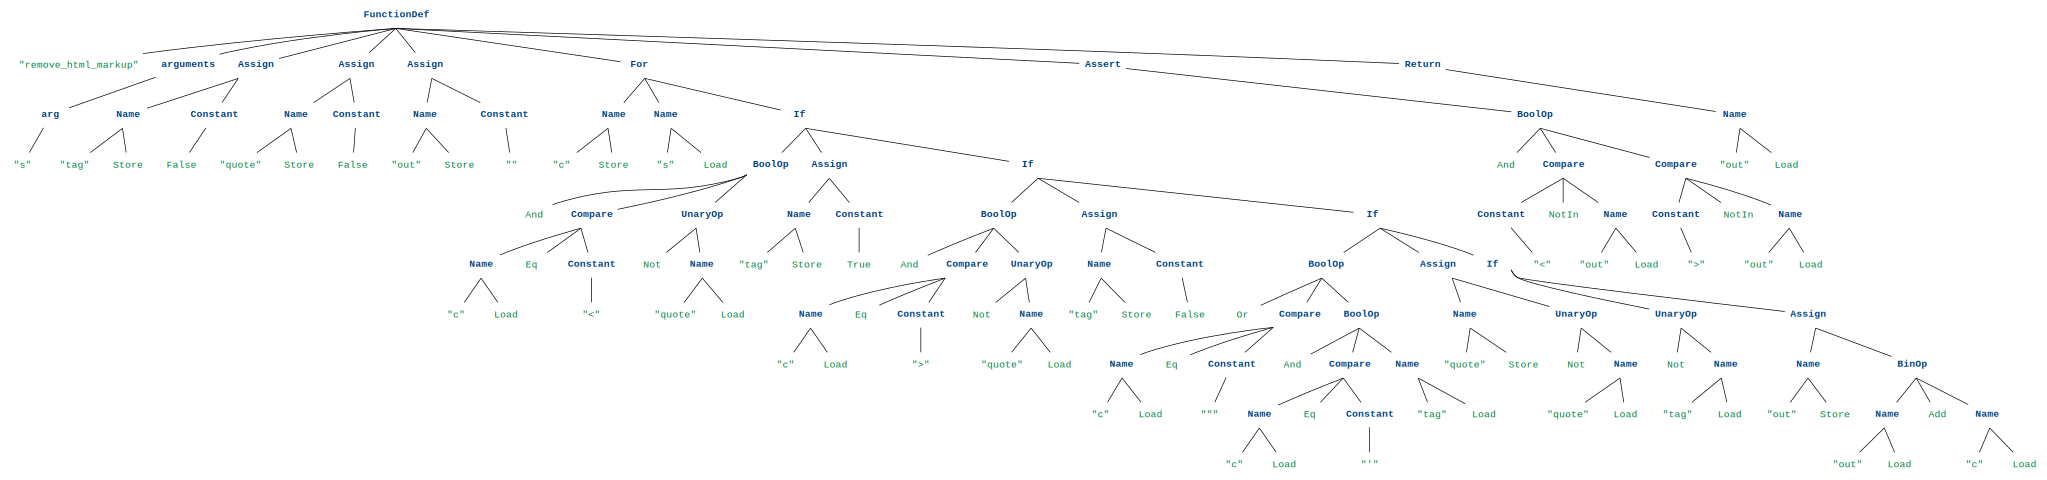

In [146]:
show_ast(fun_tree)

Let us add some tests to this, using the same scheme:

In [147]:
test_source = (
    '''if remove_html_markup('<foo>bar</foo>') != 'bar':\n''' +
    '''    raise RuntimeError("Missing functionality")\n''' +
    '''assert remove_html_markup('"foo"') == '"foo"', "My Test"'''
)

In [148]:
test_tree: ast.Module = ast.parse(test_source)

In [149]:
print_content(ast.unparse(test_tree), '.py')

if remove_html_markup('<foo>bar</foo>') != 'bar':
    raise RuntimeError('Missing functionality')
assert remove_html_markup('"foo"') == '"foo"', 'My Test'

We can merge the function definition tree and the test tree into a single one:

In [150]:
import copy

In [151]:
fun_test_tree = copy.deepcopy(fun_tree)
fun_test_tree.body += test_tree.body

Such a tree can be compiled into a code object, using Python's `compile()` function:

In [152]:
fun_test_code = compile(fun_test_tree, '<string>', 'exec')

and the resulting code object can be executed directly, using the Python `exec()` function. We see that our test fails as expected.

In [153]:
with ExpectError(AssertionError):
    exec(fun_test_code, {}, {})

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/1290587190.py", line 2, in <module>
    exec(fun_test_code, {}, {})
  File "<string>", line 3, in <module>
AssertionError: My Test (expected)


#### Traversing Syntax Trees

Our goal is now to reduce this tree (or at least the subtree with the function definition) to a minimum. 
To this end, we manipulate the AST through the `ast` Python module. The [official Python `ast` reference](http://docs.python.org/3/library/ast) is complete, but a bit brief; the documentation ["Green Tree Snakes - the missing Python AST docs"](https://greentreesnakes.readthedocs.io/en/latest/) provides an excellent introduction.

The two means for exploring and changing ASTs are the classes `NodeVisitor` and `NodeTransformer`, respectively. We start with creating a list of all nodes in the tree, using a `NodeVisitor` subclass.

Its `visit()` method is called for every node in the tree, which we achieve by having it return `self.generic_visit()` for the current node. It saves all visited nodes in the `_all_nodes` attribute.

In [154]:
from ast import NodeTransformer, NodeVisitor, AST

In [155]:
class NodeCollector(NodeVisitor):
    """Collect all nodes in an AST."""

    def __init__(self) -> None:
        super().__init__()
        self._all_nodes: List[AST] = []

    def generic_visit(self, node: AST) -> None:
        self._all_nodes.append(node)
        return super().generic_visit(node)

    def collect(self, tree: AST) -> List[AST]:
        """Return a list of all nodes in tree."""
        self._all_nodes = []
        self.visit(tree)
        return self._all_nodes

This is how our `NodeCollector()` class produces a list of all nodes:

In [156]:
fun_nodes = NodeCollector().collect(fun_tree)
len(fun_nodes)

107

In [157]:
fun_nodes[:30]

Such a list of nodes is what we can feed into Delta Debugging in order to reduce it. The idea is that with every test, we take the tree and for each node in the tree, we check whether it is still in the list – if not, we remove it. Thus, by reducing the list of nodes, we simultaneously reduce the tree as well.

#### Deleting Nodes

In our next step, we write some code that, given such a list of nodes, _prunes_ the tree such that _only_ elements in the list are still contained. To this end, we proceed in four steps:

1. We traverse the original AST, _marking_ all nodes as "to be deleted".
2. We traverse the given list of nodes, clearing their markers.
3. We copy the original tree (including the markers) into a new tree – the one to be reduced.
4. We traverse the new tree, now deleting all marked nodes.

Why do we go through such an extra effort? The reason is that our list of nodes contains references into the _original_ tree – a tree that needs to stay unchanged such that we can reuse it for later. The new tree (the copy) has the same nodes, but at different addresses, so our original references cannot be used anymore. Markers, however, just like any other attributes, are safely copied from the original into the new tree.

The `NodeMarker()` visitor marks all nodes in a tree:

In [158]:
class NodeMarker(NodeVisitor):
    def visit(self, node: AST) -> AST:
        node.marked = True  # type: ignore
        return super().generic_visit(node)

The `NodeReducer()` transformer reduces all marked nodes. If a method `visit_<node class>()` is defined, it will be invoked; otherwise, `visit_Node()` is invoked, which _deletes_ the node (and its subtree) by returning `None`. 

In [159]:
class NodeReducer(NodeTransformer):
    def visit(self, node: AST) -> Any:
        method = 'visit_' + node.__class__.__name__
        visitor = getattr(self, method, self.visit_Node)
        return visitor(node)

    def visit_Module(self, node: AST) -> Any:
        # Can't remove modules
        return super().generic_visit(node)

    def visit_Node(self, node: AST) -> Any:
        """Default visitor for all nodes"""
        if node.marked:  # type: ignore
            return None  # delete it
        return super().generic_visit(node)

Our function `copy_and_reduce()` puts these pieces together:

In [160]:
def copy_and_reduce(tree: AST, keep_list: List[AST]) -> AST:
    """Copy tree, reducing all nodes that are not in keep_list."""

    # Mark all nodes except those in keep_list
    NodeMarker().visit(tree)
    for node in keep_list:
        # print("Clearing", node)
        node.marked = False  # type: ignore

    # Copy tree and delete marked nodes
    new_tree = copy.deepcopy(tree)
    NodeReducer().visit(new_tree)
    return new_tree

Let us apply this in practice. We take the first assignment in our tree...

In [161]:
fun_nodes[4]

... whose subtree happens to be the assignment to `tag`:

In [162]:
ast.unparse(fun_nodes[4])

'tag = False'

We keep all nodes _except_ for this one.

In [163]:
keep_list = fun_nodes.copy()
del keep_list[4]

Let us now create a copy of the tree in which the assignment is missing:

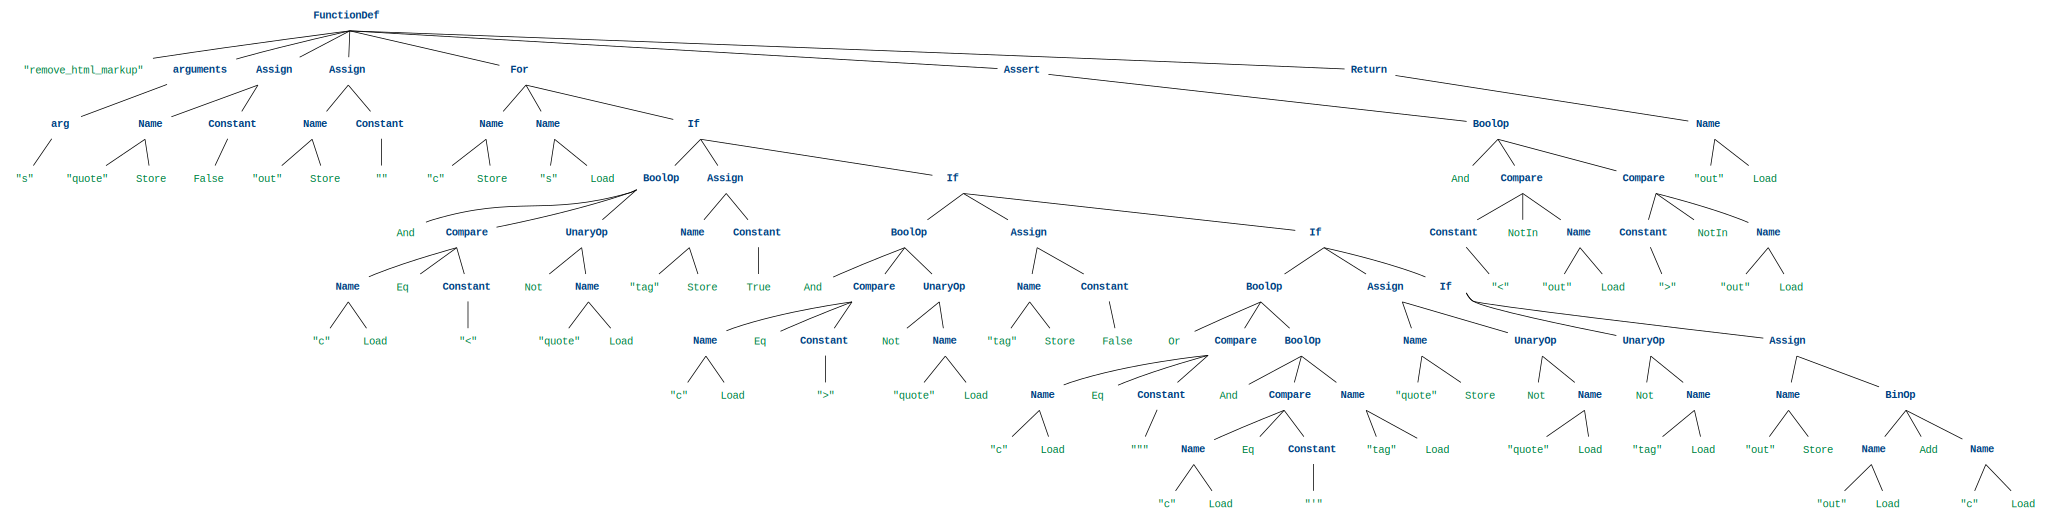

In [164]:
new_fun_tree = cast(ast.Module, copy_and_reduce(fun_tree, keep_list))
show_ast(new_fun_tree)

The new tree no longer contains the initial assignment to `tag`:

In [165]:
print_content(ast.unparse(new_fun_tree), '.py')

def remove_html_markup(s):
    quote = False
    out = ''
    for c in s:
        if c == '<' and (not quote):
            tag = True
        elif c == '>' and (not quote):
            tag = False
        elif c == '"' or (c == "'" and tag):
            quote = not quote
        elif not tag:
            out = out + c
    assert '<' not in out and '>' not in out
    return out

If we add our tests and then execute this code, we get an error, as `tag` is now no longer initialized:

In [166]:
new_fun_tree.body += test_tree.body

In [167]:
fun_code = compile(new_fun_tree, "<string>", 'exec')

In [168]:
with ExpectError(UnboundLocalError):
    exec(fun_code, {}, {})

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/2411822553.py", line 2, in <module>
    exec(fun_code, {}, {})
  File "<string>", line 3, in <module>
  File "<string>", line 13, in remove_html_markup
UnboundLocalError: local variable 'tag' referenced before assignment (expected)


If we have _no_ node in the keep list, the whole tree gets deleted:

In [169]:
empty_tree = copy_and_reduce(fun_tree, [])

In [170]:
ast.unparse(empty_tree)

''

#### Reducing Trees

We can put all these steps together in a single function. `compile_and_test_ast()` takes a tree and a list of nodes, reduces the tree to those nodes in the list, and then compiles and runs the reduced AST.

In [171]:
def compile_and_test_ast(tree: ast.Module, keep_list: List[AST], 
                         test_tree: Optional[ast.Module] = None) -> None:
    new_tree = cast(ast.Module, copy_and_reduce(tree, keep_list))
    # print(ast.unparse(new_tree))

    if test_tree is not None:
        new_tree.body += test_tree.body

    try:
        code_object = compile(new_tree, '<string>', 'exec')
    except Exception:
        raise SyntaxError("Cannot compile")

    exec(code_object, {}, {})

In [172]:
with ExpectError(AssertionError):
    compile_and_test_ast(fun_tree, fun_nodes, test_tree)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/2588008834.py", line 2, in <module>
    compile_and_test_ast(fun_tree, fun_nodes, test_tree)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/1107678207.py", line 14, in compile_and_test_ast
    exec(code_object, {}, {})
  File "<string>", line 3, in <module>
AssertionError: My Test (expected)


When we run our delta debugger on the AST, this is the list of remaining nodes we obtain:

In [173]:
with DeltaDebugger() as dd:
    compile_and_test_ast(fun_tree, fun_nodes, test_tree)

In [174]:
reduced_nodes = dd.min_args()['keep_list']
len(reduced_nodes)

57

This is the associated tree:

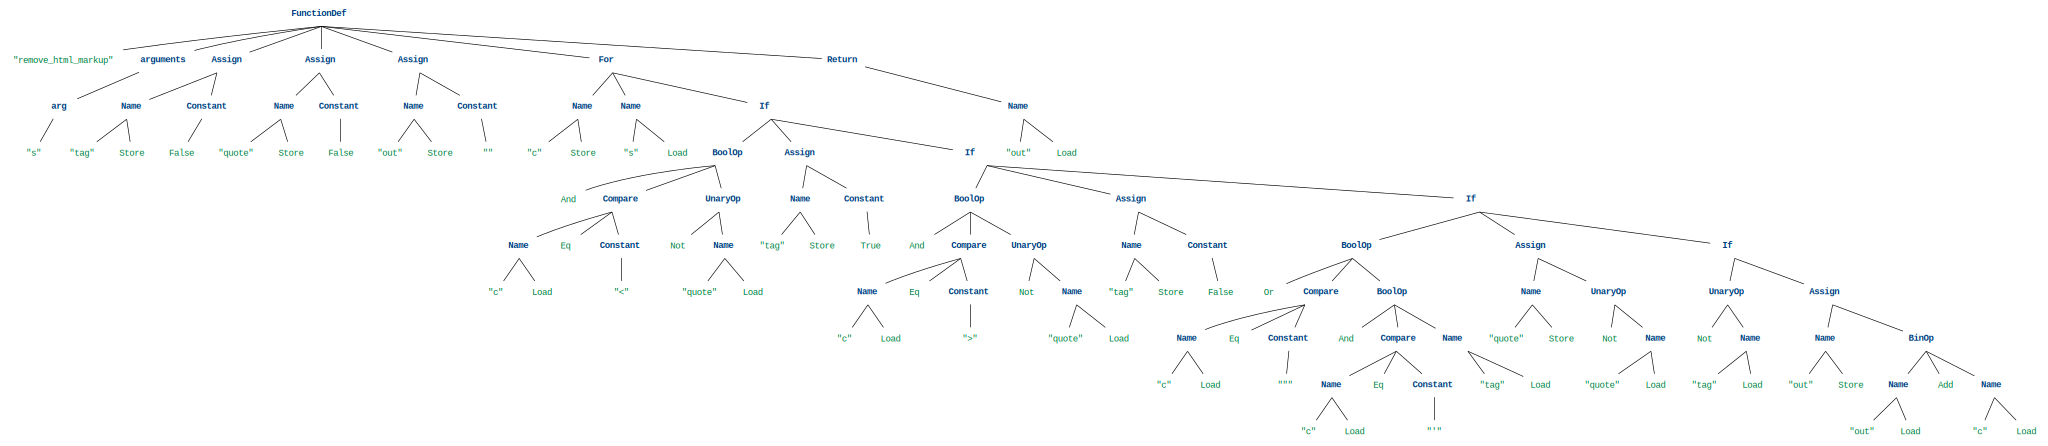

In [175]:
reduced_fun_tree = copy_and_reduce(fun_tree, reduced_nodes)
show_ast(reduced_fun_tree)

And this is its textual representation:

In [176]:
print_content(ast.unparse(reduced_fun_tree), '.py')

def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and (not quote):
            tag = True
        elif c == '>' and (not quote):
            tag = False
        elif c == '"' or (c == "'" and tag):
            quote = not quote
        elif not tag:
            out = out + c
    return out

In [177]:
dd.tests

310

We see that some code was deleted – notably the assertion at the end – but otherwise, our deletion strategy was not particularly effective. This is because in Python, one cannot simply delete the single statement in a controlled body – this raises a syntax error. One would have to replace it with `pass` (or some other statement with no effect) to stay syntactically valid. Still, the syntax-based reduction would still single out `remove_html_markup()` from the `Assertions` source code – and do so even faster, as it would apply on one definition (rather than one line) after another.

#### Transforming Nodes

To further boost our syntactic reduction strategy, we implement a set of additional reduction operators. First, as already discussed, we do not simply delete an assignment, but we replace it with a `pass` statement. To obtain the tree for `pass`, we simply parse it and access the subtree.

In [178]:
class NodeReducer(NodeReducer):
    PASS_TREE = ast.parse("pass").body[0]

    def visit_Assign(self, node: ast.Assign) -> AST:
        if node.marked:  # type: ignore
            # Replace by pass
            return self.PASS_TREE
        return super().generic_visit(node)

In a similar vein, we can replace comparison operators with `False`:

In [179]:
class NodeReducer(NodeReducer):
    FALSE_TREE = ast.parse("False").body[0].value  # type: ignore

    def visit_Compare(self, node: ast.Compare) -> AST:
        if node.marked:  # type: ignore
            # Replace by False
            return self.FALSE_TREE
        return super().generic_visit(node)

If we have a Boolean operator, we attempt to replace it with its left operand:

In [180]:
class NodeReducer(NodeReducer):
    def visit_BoolOp(self, node: ast.BoolOp) -> AST:
        if node.marked:  # type: ignore
            # Replace by left operator
            return node.values[0]
        return super().generic_visit(node)

And if we find an `If` clause, we attempt to replace it by its body:

In [181]:
class NodeReducer(NodeReducer):
    def visit_If(self, node: ast.If) -> Union[AST, List[ast.stmt]]:
        if node.marked:  # type: ignore
            # Replace by body
            return node.body
        return super().generic_visit(node)

Let us try to reduce our code with these additional reducers enabled:

In [182]:
with DeltaDebugger() as dd:
    compile_and_test_ast(fun_tree, fun_nodes, test_tree)

This is the reduced code we get. We see that all references to `quote` have gone, as has the handling of single quotes – none of this is relevant for the failure:

In [183]:
reduced_nodes = dd.min_args()['keep_list']
reduced_fun_tree = copy_and_reduce(fun_tree, reduced_nodes)
print_content(ast.unparse(reduced_fun_tree), '.py')

def remove_html_markup(s):
    tag = False
    pass
    out = ''
    for c in s:
        if c == '<':
            tag = True
        elif c == '>':
            tag = False
        elif c == '"':
            pass
        elif not tag:
            out = out + c
    return out

Again, the best insights come from comparing this reduced version to the original implementation – and we learn that the problem is not related to the `quote` variable, or to the handling of single quotes; the problem is simply that when the input contains double quotes, these are not added to the final string.

With our reduction code, however, we only touch the surface of what could actually be possible. So far, we implement exactly one reduction per node – but of course, there are many alternatives an expression or statement could be reduced to. We will explore some of these in the [exercises](#Exercises), below; also be sure to check out the [background](#Background) on code reduction.

## Synopsis

A _reducer_ takes a failure-inducing input and reduces it to the minimum that still reproduces the failure.  This chapter provides a `DeltaDebugger` class that implements such a reducer.

Here is a simple example: An arithmetic expression causes an error in the Python interpreter:

In [184]:
def myeval(inp: str) -> Any:
    return eval(inp)

In [185]:
with ExpectError(ZeroDivisionError):
    myeval('1 + 2 * 3 / 0')

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/4002351332.py", line 2, in <module>
    myeval('1 + 2 * 3 / 0')
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_45095/2200911420.py", line 2, in myeval
    return eval(inp)
  File "<string>", line 1, in <module>
ZeroDivisionError: division by zero (expected)


Can we reduce this input to a minimum? _Delta Debugging_ is a simple and robust reduction algorithm. We provide a `DeltaDebugger` class that is used in conjunction with a (failing) function call:

```python
with DeltaDebugger() as dd:
    fun(args...)
dd
```

The class automatically determines minimal arguments that cause the function to fail with the same exception as the original. Printing out the class object reveals the minimized call.

In [186]:
with DeltaDebugger() as dd:
    myeval('1 + 2 * 3 / 0')
dd

myeval(inp='3/0')

The input is reduced to the maximum: We get the essence of the division by zero.

There also is an interface to access the reduced input(s) programmatically. The method `min_args()` returns a dictionary in which all function arguments are minimized:

In [187]:
dd.min_args()

{'inp': '3/0'}

In contrast, `max_args()` returns a dictionary in which all function arguments are maximized, but still pass:

In [188]:
dd.max_args()

{'inp': '1 + 2 * 3  '}

The method `min_arg_diff()` returns a triple of 
* passing input,
* failing input, and
* their minimal failure-inducing difference:

In [189]:
dd.min_arg_diff()

({'inp': ' 3 '}, {'inp': ' 3 /0'}, {'inp': '/0'})

And you can also access the function itself, as well as its original arguments.

In [190]:
dd.function().__name__, dd.args()

('myeval', {'inp': '1 + 2 * 3 / 0'})

`DeltaDebugger` processes (i.e., minimizes or maximizes) all arguments that support a `len()` operation and that can be indexed – notably _strings_ and _lists_. If a function has multiple arguments, all arguments that can be processed will be processed.

This chapter also provides a number of superclasses to `DeltaDebugger`, notably `CallCollector`, which obtains the first function call for `DeltaDebugger`. `CallReducer` classes allow for implementing alternate call reduction strategies.

In [191]:
# ignore
from ClassDiagram import display_class_hierarchy

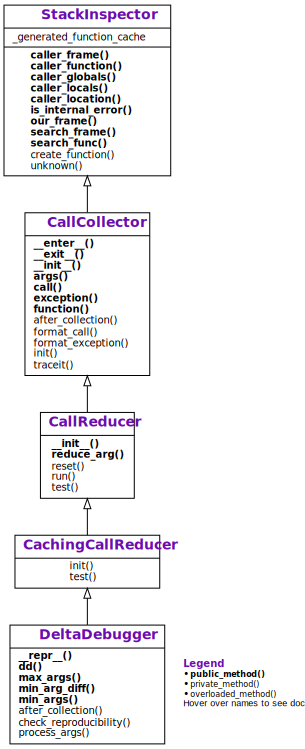

In [192]:
# ignore
display_class_hierarchy([DeltaDebugger],
                        public_methods=[
                            StackInspector.caller_frame,
                            StackInspector.caller_function,
                            StackInspector.caller_globals,
                            StackInspector.caller_locals,
                            StackInspector.caller_location,
                            StackInspector.search_frame,
                            StackInspector.search_func,
                            StackInspector.is_internal_error,
                            StackInspector.our_frame,
                            CallCollector.__init__,
                            CallCollector.__enter__,
                            CallCollector.__exit__,
                            CallCollector.function,
                            CallCollector.args,
                            CallCollector.exception,
                            CallCollector.call,
                            CallReducer.__init__,
                            CallReducer.reduce_arg,
                            DeltaDebugger.dd,
                            DeltaDebugger.min_args,
                            DeltaDebugger.max_args,
                            DeltaDebugger.min_arg_diff,
                            DeltaDebugger.__repr__
                        ],
                        project='debuggingbook')

## Lessons Learned

* Reducing failure-inducing inputs to a minimum is helpful for testing and debugging.
* _Delta debugging_ is a simple and robust algorithm to easily reduce inputs of test cases, as well as their code.
* Precisely specifying failure conditions helps avoiding false diagnoses.

## Next Steps

Our next chapter focuses on [finding _failure-inducing code changes_](ChangeDebugger.ipynb), using delta debugging and version control systems.

## Background

The "lexical" delta debugging algorithm discussed here – both in its simplifying `ddmin` as well as in its general `dd` form – stem from \cite{Zeller2002}; actually, `ddmin` is the exact Python implementation as used by Zeller in 2002. The `ddmax` variant was first evaluated in \cite{Kirschner2020}. This chapter is the first to show how both `ddmin` and `ddmax` can be implemented as small variations of `dd`.

The idea of systematically reducing inputs has been discovered a number of times, although not as  automatic and generic as delta debugging. \cite{Slutz1998}, for instance, discusses systematic reduction of SQL statements for SQL databases; the general process as manual work is well described by \cite{Kernighan1999}.

The deficits of delta debugging as it comes to syntactically complex inputs were first discussed in *compiler testing*, and _reducing tree inputs_ rather than string inputs was quickly discovered as an alternative.  *Hierarchical Delta Debugging* (*HDD*) \cite{Misherghi2006} applies delta debugging on subtrees of a parse tree, systematically reducing a parse tree to a minimum.  _Generalized Tree Reduction_ \cite{Herfert2017} generalizes this idea to apply arbitrary _patterns_ such as replacing a term by a compatible term in a subtree.  Using _grammars_ to reduce inputs was first implemented in the _Perses_ tool \cite{Sun2018}. [A Python implementation of grammar-based input reduction](https://www.fuzzingbook.org/html/Reducer.html#Grammar-Based-Input-Reduction) is part of "The Fuzzing Book".

While applying delta debugging to code lines does a decent job, _syntactic_ and especially _language-specific_ approaches can do a much better job for the programming language at hand:

* *C-Reduce* \cite{Regehr2012} is a reducer specifically targeting the reduction of programming languages.  Besides reductions in the style of delta debugging or tree transformations, C-Reduce comes with more than 30 source-to-source transformations that replace aggregates by scalars, remove function parameters at a definition and all call sites, change functions to return `void` and deleting all `return` statements, and many more.  While specifically instantiated for the C language (and used for testing C compilers), these principles extend to arbitrary programming languages following an ALGOL-like syntax.

* Kalhauge and Palsberg \cite{Kalhauge2019} introduce *binary reduction of dependency graphs*, a general solution for reducing arbitrary inputs with dependencies. Their *J-Reduce* tool specifically targets Java programs, and again is much faster than delta debugging and achieves a higher reduction rate.

This [blog post](https://www.drmaciver.com/2019/01/notes-on-test-case-reduction/) by David McIver contains lots of insights on how to apply reduction in practice, in particular multiple runs with different abstraction levels.

## Exercises

How to best reduce inputs is still an underdeveloped field of research, with lots of opportunities.

### Exercise 1: Advanced Syntactic Code Reduction

Extend the code in ["Transforming Nodes"](#Transforming-Nodes) such that _multiple_ reduction possibilities for a node are being considered. For instance:

* Replace a `BoolOp` node by `True`.
* Replace a `BoolOp` node by `False`.
* Replace a `BoolOp` node by its left operand.
* Replace a `BoolOp` node by its right operand.

or:

* Replace an `If` node by its "then" body.
* Replace an `If` node by its "else" body.

or:

* Replace all instances of a variable by a constant.

or:

* Replace expressions by a constant.

Have a look at the [official Python `ast` reference](http://docs.python.org/3/library/ast) for a list of nodes (and some ideas on what to replace them by). The documentation ["Green Tree Snakes - the missing Python AST docs"](https://greentreesnakes.readthedocs.io/en/latest/) provides an excellent introduction on visitors and transformers. Make copious use of AST visualization and tests to ensure your syntax trees are still correct.

Strategy-wise, you should first create a list of _possible_ reductions; and then pass to Delta Debugging a "keep list" of reductions that should _not_ be applied. When Delta Debugging minimizes this list, it will apply as many reductions as possible.